In [10]:
# Supressing Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import libraries
from pandas import read_csv
from matplotlib import pyplot
from numpy import sqrt
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_predict

In [6]:
series = read_csv('C:/Users\Moin Dalvi\Documents\Data Science Material\Data Science\Python\Datasets/water.csv', header=0, index_col=0, parse_dates=True)
series

,Water
Year,
1885-01-01,356
1886-01-01,386
1887-01-01,397
1888-01-01,397
1889-01-01,413
...,...
1959-01-01,594
1960-01-01,587
1961-01-01,587


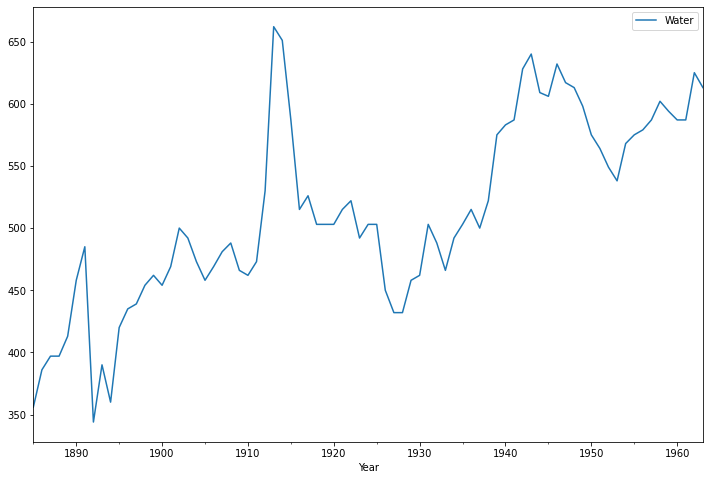

<Figure size 864x576 with 0 Axes>

In [6]:
# line plot of time series
series.plot(figsize=(12,8))
pyplot.show()

array([[<AxesSubplot:title={'center':'Water'}>]], dtype=object)

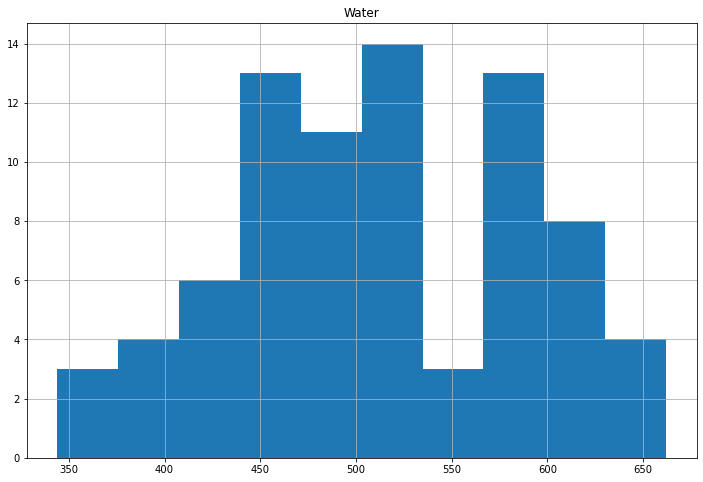

In [9]:
series.hist(figsize=(12,8))

<AxesSubplot:ylabel='Density'>

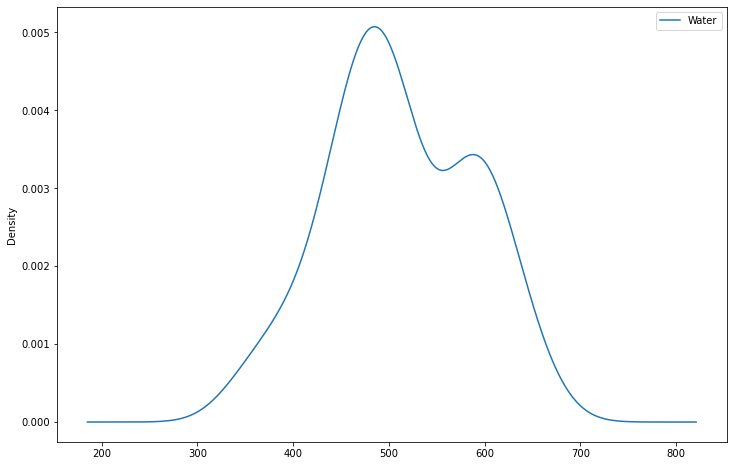

In [10]:
series.plot(kind='kde',figsize=(12,8))

In [11]:
split_point = len(series) - 10
split_point

69

In [12]:
len(series)

79

In [13]:
series[0:split_point]

,Water
Year,
1885-01-01,356
1886-01-01,386
1887-01-01,397
1888-01-01,397
1889-01-01,413
...,...
1949-01-01,598
1950-01-01,575
1951-01-01,564


In [14]:
series[split_point:]

,Water
Year,
1954-01-01,568
1955-01-01,575
1956-01-01,579
1957-01-01,587
1958-01-01,602
1959-01-01,594
1960-01-01,587
1961-01-01,587
1962-01-01,625


In [12]:
dataset, validation = series[0:split_point], series[split_point:]

In [11]:
# separate out a validation dataset
split_point = len(series) - 10
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

Dataset 69, Validation 10


### Persistence/ Base model

In [8]:
# evaluate a persistence model

# load data
train = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = train.values
X = X.astype('float32')
train_size = int(len(X) * 0.70)
train, test = X[0:train_size], X[train_size:]

In [25]:
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    yhat = history[-1]
    predictions.append(yhat)
# observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=488.000, Expected=466.000
>Predicted=466.000, Expected=492.000
>Predicted=492.000, Expected=503.000
>Predicted=503.000, Expected=515.000
>Predicted=515.000, Expected=500.000
>Predicted=500.000, Expected=522.000
>Predicted=522.000, Expected=575.000
>Predicted=575.000, Expected=583.000
>Predicted=583.000, Expected=587.000
>Predicted=587.000, Expected=628.000
>Predicted=628.000, Expected=640.000
>Predicted=640.000, Expected=609.000
>Predicted=609.000, Expected=606.000
>Predicted=606.000, Expected=632.000
>Predicted=632.000, Expected=617.000
>Predicted=617.000, Expected=613.000
>Predicted=613.000, Expected=598.000
>Predicted=598.000, Expected=575.000
>Predicted=575.000, Expected=564.000
>Predicted=564.000, Expected=549.000
>Predicted=549.000, Expected=538.000
RMSE: 21.774


### ARIMA Hyperparameters

In [3]:
# grid search ARIMA parameters for a time series

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
# prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.70)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
# make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
# model_fit = model.fit(disp=0)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
# calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

### Grid search for p,d,q values

In [4]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except Exception as e:
                    print(e)
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [11]:
# load dataset
train = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# evaluate parameters
p_values = range(0, 5)
d_values = range(0, 5)
q_values = range(0, 5)
evaluate_models(train.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=95.357
ARIMA(0, 0, 1) RMSE=57.592
ARIMA(0, 0, 2) RMSE=42.662
ARIMA(0, 0, 3) RMSE=37.686
ARIMA(0, 0, 4) RMSE=33.647
ARIMA(0, 1, 0) RMSE=21.774
ARIMA(0, 1, 1) RMSE=21.637
ARIMA(0, 1, 2) RMSE=21.909
ARIMA(0, 1, 3) RMSE=25.936
ARIMA(0, 1, 4) RMSE=26.148
ARIMA(0, 2, 0) RMSE=27.191
ARIMA(0, 2, 1) RMSE=21.840
ARIMA(0, 2, 2) RMSE=21.645
ARIMA(0, 2, 3) RMSE=21.683
ARIMA(0, 2, 4) RMSE=25.878
ARIMA(0, 3, 0) RMSE=44.783
ARIMA(0, 3, 1) RMSE=27.461
ARIMA(0, 3, 2) RMSE=23.545
ARIMA(0, 3, 3) RMSE=23.193
ARIMA(0, 3, 4) RMSE=23.291
ARIMA(0, 4, 0) RMSE=78.291
ARIMA(0, 4, 1) RMSE=45.219
ARIMA(0, 4, 2) RMSE=28.260
ARIMA(0, 4, 3) RMSE=27.503
ARIMA(0, 4, 4) RMSE=25.799
ARIMA(1, 0, 0) RMSE=25.621
ARIMA(1, 0, 1) RMSE=25.725
ARIMA(1, 0, 2) RMSE=27.566
ARIMA(1, 0, 3) RMSE=27.308
ARIMA(1, 0, 4) RMSE=27.376
ARIMA(1, 1, 0) RMSE=21.664
ARIMA(1, 1, 1) RMSE=21.595
ARIMA(1, 1, 2) RMSE=24.021
ARIMA(1, 1, 3) RMSE=26.103
ARIMA(1, 1, 4) RMSE=26.359
ARIMA(1, 2, 0) RMSE=27.310
ARIMA(1, 2, 1) RMSE=21.682
A

### Build Model based on the optimized values

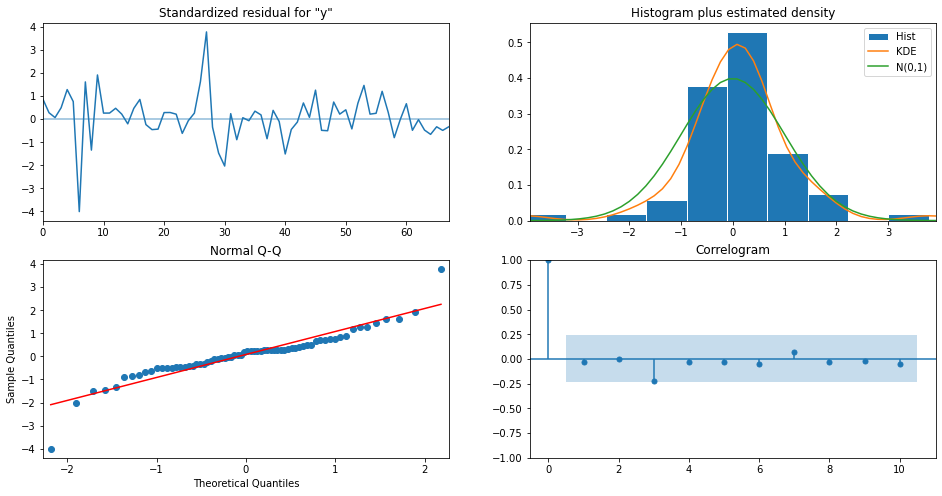

In [9]:
# fit model
model = ARIMA(X, order=(2, 1, 0))
model_fit = model.fit()
forecast=model_fit.forecast(steps=10)[0]
#model_fit.plot_predict(1, 79)
with plt.rc_context():
    plt.rc("figure", figsize=(16,8))
    model_fit.plot_diagnostics()
    plt.show()

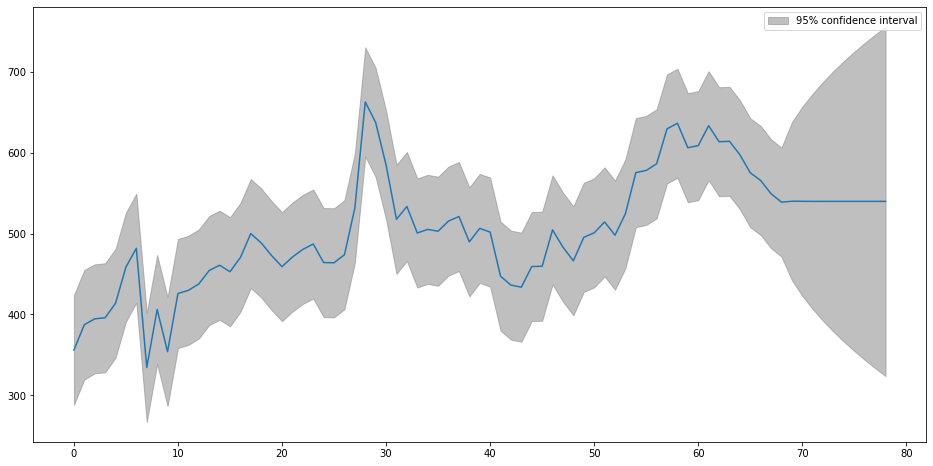

In [42]:
# fit model

model = ARIMA(X, order=(2, 1, 0))
model_fit = model.fit()
forecast=model_fit.forecast(steps=10)
with plt.rc_context():
    plt.rc("figure", figsize=(16,8))
    plot_predict(model_fit,1, 79)
    plt.show()

In [54]:
forecast

538.9291743073546

In [21]:
#Error on the test data
val=pd.read_csv('validation.csv',header=None)
model = ARIMA(val[1], order=(2,1,0))
model_fit = model.fit()
forecast=model_fit.forecast(steps=10)
rmse = sqrt(mean_squared_error(val[1], forecast))
rmse

22.48718712612483

In [22]:
forecast

10    601.416991
11    607.473094
12    610.629613
13    607.992788
14    607.286497
15    608.330343
16    608.417576
17    608.034358
18    608.063257
19    608.194440
Name: predicted_mean, dtype: float64

In [23]:
val[1]

0    568
1    575
2    579
3    587
4    602
5    594
6    587
7    587
8    625
9    613
Name: 1, dtype: int64

### Combine train and test data and build final model

In [43]:
model = ARIMA(series.Water, order=(2,1,0))
model_fit = model.fit()

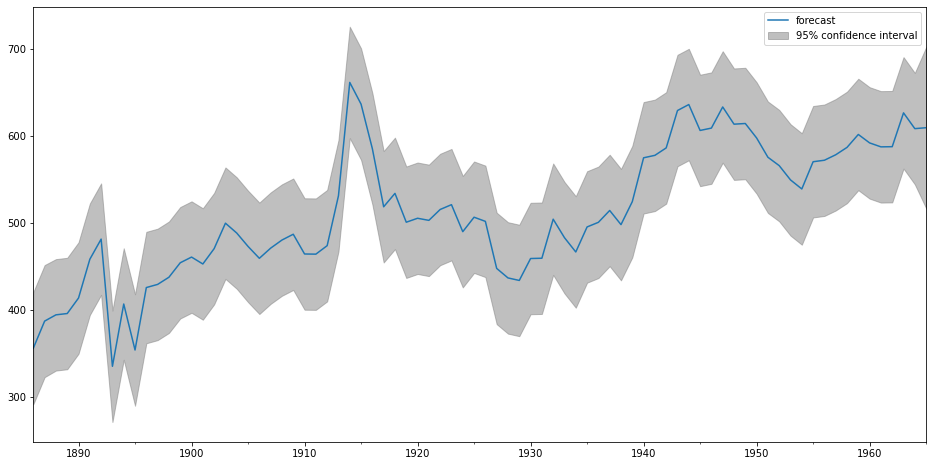

In [44]:
forecast=model_fit.forecast(steps=10)
with plt.rc_context():
    plt.rc("figure", figsize=(16,8))
    plot_predict(model_fit,1, 80)
    plt.show()

In [41]:
forecast

1964-01-01    608.496981
1965-01-01    609.563839
1966-01-01    610.082239
1967-01-01    609.992446
1968-01-01    609.934181
1969-01-01    609.941112
1970-01-01    609.947525
1971-01-01    609.947072
1972-01-01    609.946379
1973-01-01    609.946397
Freq: AS-JAN, Name: predicted_mean, dtype: float64

In [45]:
series

,Water
Year,
1885-01-01,356
1886-01-01,386
1887-01-01,397
1888-01-01,397
1889-01-01,413
...,...
1959-01-01,594
1960-01-01,587
1961-01-01,587
